# Multilayer Perceptrons in PyTorch

In this example I'll create a feedforward neural network, often loosely termed a multilayer perceptron (MLP), and illustrate how we can train the parameters of the MLP using SGD.

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from torchviz import make_dot

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Non-linearly Separable Problem

As described in class, a problem of using single artificial neurons without hidden layers is their limited capacity to separate data that is not linearly separable. For instance, let's consider a neuron modelled as a <b>perceptron</b>, also known as the heaviside step function or linear threshold function:

\begin{equation}
g(a) = \begin{cases}
          1 \quad &\text{if} \, a \geq 0 \\
          0 \quad &\text{otherwise} \\
     \end{cases}
\end{equation}

where $a$ are our pre-activation values. Without any hidden layers, these pre-activations would simply be a linear combination of the inputs $\mathbf{x}$ with their connection weights $\mathbf{w}$ and a bias term $b$, such that $a(\mathbf{x}) = \mathbf{w}^\intercal \mathbf{x} + b$.

The above perceptron is an <b>activation function</b>, but you can also consider another one you know - the sigmoid:

$$g(a) = \frac{1}{1 + e^{-a}} = \frac{e^a}{e^a + 1}.$$

A prevalent way of illustrating the issue of using single neurons to model data with non-linearly separable regions, is the XOR logic gate problem. For inputs $x_1$ and $x_2$, this has the following truth table:

| x1 | x2 | XOR(x1,x2) |
|:-:|:-:|:--------:|
| 0 | 0 | 0        |
| 0 | 1 | 1        |
| 1 | 0 | 1        |
| 1 | 1 | 0        |

If we plot this function for the two input values, as can be seen in the below cell of code, then it is clear that we cannot draw a single line that separates out the 0 and 1s.

Instead, the below code looks at an MLP that transforms the inputs into a representation that leads to a linearly separable form of the XOR gate problem.

See references for where [code snippet](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/13/xor_heaviside.ipynb) below was adapted from.

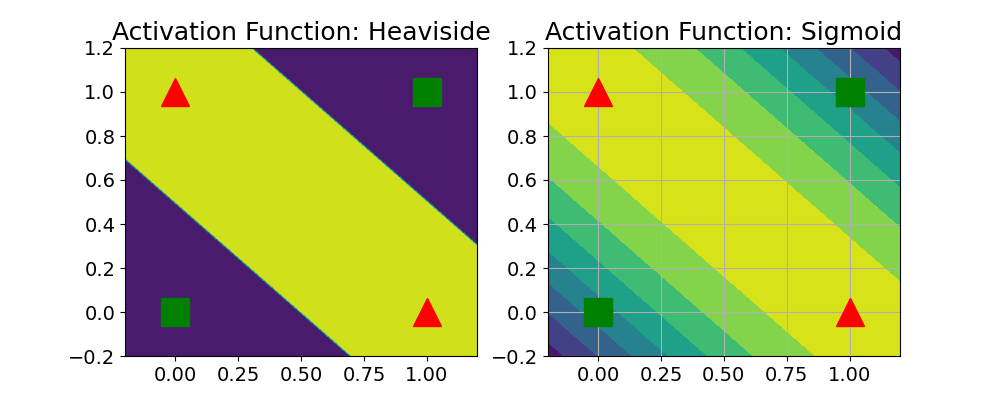

In [2]:
# Perceptron 
def heaviside(a):
    return (a >= 0).astype(a.dtype)

# Logistic/Sigmoid
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

# MLP for the XOR gate, where we assume we know the weights and bias terms to define our decision boundaries
def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)


# Create a grid of coordinates over the input space
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

# Single artificial neuron
z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
cs1 = plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "r^", markersize=20)
plt.title("Activation Function: Heaviside")

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "r^", markersize=20)
plt.title("Activation Function: Sigmoid")
plt.grid(True)
plt.show()

### Dataset

That previous XOR gate function is a toy example, but why not consider the case where maybe you have a training dataset $\mathcal{D}_\text{train} = \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^N$, where $\mathbf{x} \in \mathbb{R}^2$ is two-dimensional and there are three classes $C=3$, such that $y \in \{0, 1, 2\}$. 

Let's sample from five multivariate Gaussians and color-code the individual components based on their labels to specify this dataset:

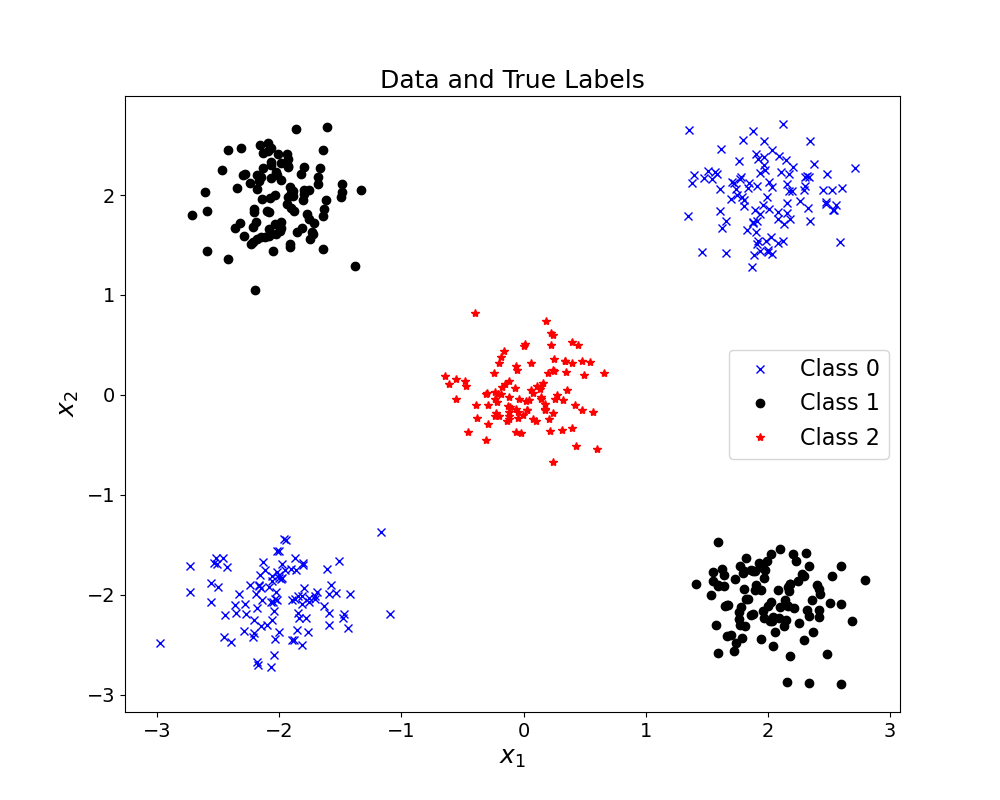

In [3]:
N = 100

def create_data(N):
    # Uses the same covariance matrix, scaled identity, for all Gaussians
    Sigma = 0.1 * np.eye(2)
    # Five gaussian means specified to span a square and its centre
    Gs = [
        mvn(mean=[2, 2], cov=Sigma),
        mvn(mean=[-2, -2], cov=Sigma),
        mvn(mean=[2, -2], cov=Sigma),
        mvn(mean=[-2, 2], cov=Sigma),
        mvn(mean=[0, 0], cov=Sigma),
    ]
    # Draw random variable samples and assign labels, note class 3 has less samples altogether
    X = np.concatenate([G.rvs(size=N) for G in Gs])
    y = np.concatenate((np.zeros(N), np.zeros(N), np.ones(N), np.ones(N), 2 * np.ones(N)))
    
    # Will return an X and y of shapes (5*N, 2) and (5*N)
    # Representing our dataset of 2D samples
    return X, y


X, y = create_data(N)
C = len(np.unique(y))

plt.figure(figsize=(10,8))
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Labels")
plt.legend()
plt.show()

## Multinomial Logistic Regression

Before proceeding with MLPs, let's cover a quick point on multinomial (multi-class) logistic regression. Recall that for binary logistic regression, the model was a Bernoulli: 

\begin{align*}
P(y \, | \, \mathbf{x}; \boldsymbol{\theta}) & = \text{Ber}\left(y \, | \, g(\mathbf{w}^\intercal \mathbf{x} + b)\right) \\
 & = g\left(\mathbf{w}^\intercal \mathbf{x} + b\right)^y \left(1-g(\mathbf{w}^\intercal \mathbf{x} + b)\right)^{(1-y)},
\end{align*}

where $g(a)$ is the sigmoid function defined above, $\mathbf{x} \in \mathbb{R}^n$ the inputs, $\mathbf{w} \in \mathbb{R}^n$ the weights vector and $b \in \mathbb{R}$ the bias term.

In the multi-class case, we instead model a [Categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution):

\begin{equation*}
P(y \, | \, \mathbf{x}; \boldsymbol{\theta}) = \text{Cat}\left(y \, | \, S(\mathbf{W}^\intercal \mathbf{x} + \mathbf{b})\right) 
\end{equation*}

where the pmf for a categorical distribution is:

\begin{equation*}
P(y = c \, | \, \mathbf{x}; \boldsymbol{\theta}) = \theta_c,
\end{equation*}

with $\boldsymbol{\theta}=(\theta_{1},\ldots ,\theta_{C})$, $\theta_{c}$ as the probability of observing class $c$, adhering to $\textstyle {\sum_{c=1}^{C}\theta_{c}=1}$.

As for the other terms in the mulinomial logistic regression model, there is a weights matrix $\mathbf{W} \in \mathbb{R}^{C \times n}$ and a bias vector $\mathbf{b} \in \mathbb{R}^C$ to output a $C$-dimensional vector of <b>logits</b> $\mathbf{a}$ (multinomial logit, or in neural network terminology: pre-activations). Therefore, for this logits vector the softmax function $S(\mathbf{a})$ is defined as:
    
\begin{equation*}
S(\mathbf{a}) = \left[\frac{e^{a_1}}{\sum_{c'=1}^{C} e^{a_c'}}, \cdots, \frac{e^{a_C}}{\sum_{c'=1}^{C} e^{a_c'}} \right]
\end{equation*}

Where importantly the softmax function normalizes the input vector $\mathbf{a}$ of logits by dividing by the sum of all exponentials (for each element in the logits vector), which ensures that each entry of the function outputs a valid probability $0 \leq S(\mathbf{a})_c \leq 1$ and satisfies $\textstyle {\sum_{c=1}^{C}S(\mathbf{a})_c=1}$. We can thus write the above classification model as:

\begin{equation*}
P(y = c \, | \, \mathbf{x}; \boldsymbol{\theta}) = S(\mathbf{a})_c = \frac{e^{a_c}}{\sum_{c'=1}^{C} e^{a_c'}}.
\end{equation*}

The code below defines a softmax function (with additional lines for numerical stability reasons due to the exponential).

In [4]:
def softmax(x):
    # Numerically stable with large exponentials (log-sum-exp trick if you're curious)
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)

I could follow the same procedure as in [previous notebooks on MLE](lin_reg_mle.ipynb) to find the optimal parameter estimates $\boldsymbol{\hat{\theta}_{\text{MLE}}} = (\mathbf{W}^*, \mathbf{b}^*)$ for my multinomial logistic regression model. In particular, I would optimize over the negative log-likelihood, which can be shown as equivalent to minimizing cross entropy (for binary logistic regression this was also true). However, to keep things concise, I'll use the scikit-learn open-source implementation for [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

In [5]:
# Use default optimizer, regularization settings, infers that it's a multiclass problem etc
model = LogisticRegression()

# "Fit" or train the parameters of the model (using MLE)
fitted_model = model.fit(X, y)

The digression here is a brief and quick snap at multi-class logistic regression just so we can observe the following decision boundary formed using this linear model over our training dataset $D_\text{train}$:

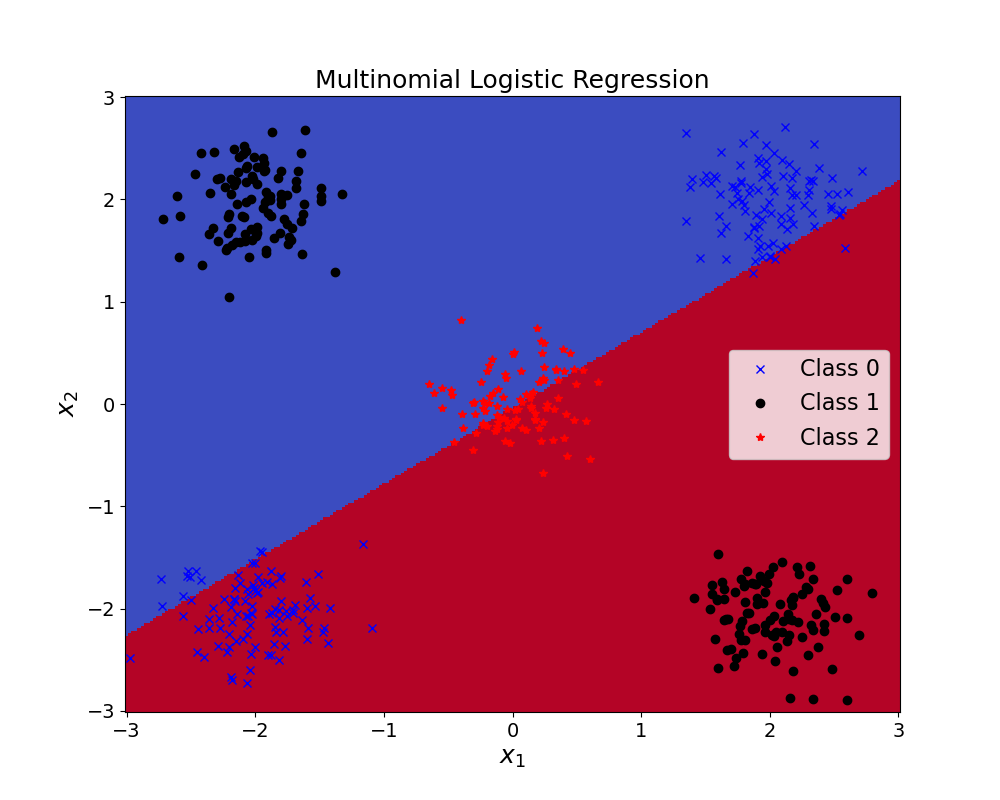

In [6]:
# Create coordinate matrices determined by the sample space
xx, yy = np.meshgrid(np.linspace(-3, 3, 250), np.linspace(-3, 3, 250))

grid = np.c_[xx.ravel(), yy.ravel()]

# Z matrix are the predictions resulting from softmax on the provided model parameters
Z = model.predict(grid).reshape(xx.shape)

plt.figure(figsize=(10,8))

# uses gray background for black dots
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)

plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Multinomial Logistic Regression")
plt.legend()
plt.show()

## Multilayer Neural Network

Let's now use [PyTorch](https://pytorch.org/) and put together an MLP that will be capable of separating the classes irrespective of the input's non-linearly separable space.

To begin with, we'll define an MLP class that consists of a single hidden layer (2-layer architecture altogether) with a ReLU activation function:

In [7]:
class TwoLayerMLP(nn.Module):
    # The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
    # the output when validating, on top of calculating the negative-log-likelihood using 
    # nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
    
    def __init__(self, d_in, d_hidden, C):
        super(TwoLayerMLP, self).__init__()
        
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_hidden, C)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)  # fc to perceptrons
        x = self.relu(x) # or self.softplus(x) for smooth-ReLU, empirically worse than ReLU
        x = self.fc2(x)  # connect to output layer
        x = self.log_softmax(x)  # for outputs that sum to 1
        return x

In [8]:
def train_model(model, data, labels, criterion, optimizer, num_epochs=25):
    # Set up training data
    X_train = torch.FloatTensor(data)
    y_train = torch.LongTensor(labels)

    # Optimize the neural network
    for epoch in range(num_epochs):
        # Set grads to zero explicitly before backprop
        optimizer.zero_grad()
        outputs = model(X_train)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, y_train)
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()

    return model

model = TwoLayerMLP(X.shape[1], 16, C)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

model = train_model(model, X, y, criterion, optimizer, num_epochs=100)

torch.Size([16, 2])
torch.Size([16])
torch.Size([3, 16])
torch.Size([3])
Total number of parameters = 99


Visualize the decision boundary obtained using our 2-layer neural network:

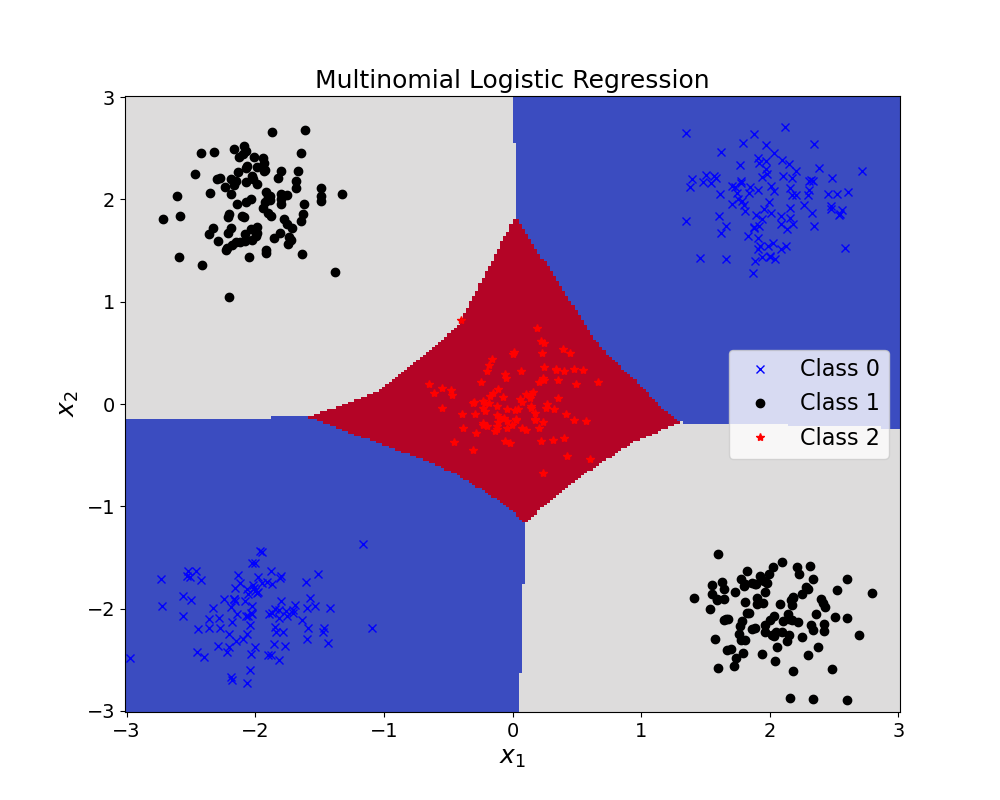

In [9]:
def model_predict(model, data):
    # Set up test data as tensor
    X_test = torch.FloatTensor(data)

    # Evaluate nn on test data and compare to true labels
    predicted_labels = model(X_test)
    # Back to numpy
    predicted_labels = predicted_labels.detach().numpy()
    
    return np.argmax(predicted_labels, 1)

# Z matrix are the predictions resulting from the forward pass through the network
Z = model_predict(model, grid).reshape(xx.shape)

plt.figure(figsize=(10,8))

# uses gray background for black dots
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)
    
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Multinomial Logistic Regression")
plt.legend()
plt.show()

## References

XOR gate code adapted from <i>"xor_heaviside.ipynb"</i> and <i>"logreg_multiclass_demo"</i> at:

@book{pml1Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: An introduction",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2022,<br>
&emsp; url = "probml.ai"<br>
}